# 📊 Pipeline de Preprocesamiento ECG - Demo y Visualizaciones

Este notebook demuestra el uso del módulo `ecg_preprocessing.py` para:
1. Cargar datos crudos desde PTB-XL y MIMIC-IV-ECG
2. Aplicar filtrado y limpieza de señales
3. Normalizar señales usando min-max scaling
4. Construir el dataset final
5. Generar splits train/valid/test **asegurando que train solo contiene normales**

## 📋 Contenido

- **Sección 1**: Setup e importaciones
- **Sección 2**: Carga de datos crudos
- **Sección 3**: Filtrado y normalización
- **Sección 4**: Construcción del dataset
- **Sección 5**: Generación de splits
- **Sección 6**: Estadísticas y conteos
- **Sección 7**: Visualizaciones antes/después del procesamiento
- **Sección 8**: Verificación de que train solo contiene normales


## 1. Setup e Importaciones

Importamos las librerías necesarias y el módulo de preprocesamiento.


In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# Importar ipywidgets para visualización interactiva
try:
    from ipywidgets import interact, IntSlider, fixed
    WIDGETS_AVAILABLE = True
except ImportError:
    print("⚠ ipywidgets no está instalado. Instálalo con: pip install ipywidgets")
    print("⚠ La visualización interactiva no estará disponible")
    WIDGETS_AVAILABLE = False
    # Crear stubs para evitar errores
    def interact(*args, **kwargs):
        raise ImportError("ipywidgets no está instalado")
    IntSlider = None
    fixed = None

# Importar el módulo de preprocesamiento
import ecg_preprocessing as ecg

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Módulos importados correctamente")
if WIDGETS_AVAILABLE:
    print("✓ ipywidgets disponible para visualización interactiva")
print(f"✓ Directorio de datos: {ecg.DATA_DIR}")


✓ Módulos importados correctamente
✓ ipywidgets disponible para visualización interactiva
✓ Directorio de datos: S:\Proyecto final\data


## 2. Carga de Datos Crudos

Cargamos los datos desde PTB-XL y MIMIC-IV-ECG. Si los archivos ya existen, se omitirá la regeneración a menos que se use `overwrite=True`.


In [3]:
print("=" * 60)
print("CARGANDO DATOS CRUDOS...")
print("=" * 60)

# Cargar datos combinados (PTB-XL + MIMIC)
# Nota: Si los archivos ya existen, se omitirá la regeneración
# Usa overwrite=True si necesitas regenerar desde cero

dataset_report = ecg.load_raw_data(
    dataset="combined",
    overwrite=False,  # Cambiar a True para regenerar
    max_anom_ptb=ecg.PTB_MAX_ANOM,
    max_anom_mimic=ecg.MIMIC_MAX_ANOM
)

print("\n📦 Resumen de carga:")
print(json.dumps(dataset_report, indent=2))


CARGANDO DATOS CRUDOS...
[PTB-XL] Artefactos existentes, omitiendo extracción.
[MIMIC] Artefactos existentes, omitiendo extracción.
[COMBINED] Normales totales 151606 | anómalos 1000

📦 Resumen de carga:
{
  "dataset": "combined",
  "status": "generated",
  "normals_total": 151606,
  "normals_ptb": 9069,
  "normals_mimic": 142537,
  "anomalies_total": 1000,
  "output_root": "S:\\Proyecto final\\data\\combined_ptbxl_mimic_500hz_iv1v5"
}


## 3. Estadísticas del Dataset

Obtenemos estadísticas generales del dataset cargado.


In [4]:
print("=" * 60)
print("ESTADÍSTICAS DEL DATASET")
print("=" * 60)

stats = ecg.get_dataset_stats(dataset="combined")

print(f"\n📊 Conteo Total:")
print(f"  • Total ECG: {stats['total_ecg']}")
print(f"  • ECG Normales: {stats['total_normals']}")
print(f"  • ECG Anómalos: {stats['total_anomalies']}")

if "train" in stats:
    print(f"\n📈 Distribución por Split:")
    print(f"  TRAIN:")
    print(f"    - Normales: {stats['train']['normals']}")
    print(f"    - Anómalos: {stats['train']['anomalies']} (debe ser 0)")
    print(f"  VALIDACIÓN:")
    print(f"    - Normales: {stats['val']['normals']}")
    print(f"    - Anómalos: {stats['val']['anomalies']}")
    print(f"  TEST:")
    print(f"    - Normales: {stats['test']['normals']}")
    print(f"    - Anómalos: {stats['test']['anomalies']}")

# Crear tabla resumen
if "train" in stats:
    summary_df = pd.DataFrame({
        "Split": ["Train", "Validación", "Test"],
        "Normales": [
            stats['train']['normals'],
            stats['val']['normals'],
            stats['test']['normals']
        ],
        "Anómalos": [
            stats['train']['anomalies'],
            stats['val']['anomalies'],
            stats['test']['anomalies']
        ],
        "Total": [
            stats['train']['normals'] + stats['train']['anomalies'],
            stats['val']['normals'] + stats['val']['anomalies'],
            stats['test']['normals'] + stats['test']['anomalies']
        ]
    })
    print("\n📋 Tabla Resumen:")
    display(summary_df)


ESTADÍSTICAS DEL DATASET

📊 Conteo Total:
  • Total ECG: 152606
  • ECG Normales: 151606
  • ECG Anómalos: 1000

📈 Distribución por Split:
  TRAIN:
    - Normales: 121284
    - Anómalos: 0 (debe ser 0)
  VALIDACIÓN:
    - Normales: 15160
    - Anómalos: 100
  TEST:
    - Normales: 15162
    - Anómalos: 900

📋 Tabla Resumen:


s:\Proyecto final\Books\ecg_preprocessing.py:1252: DtypeWarning: Columns (1,5) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_norm = pd.read_csv(output_dir / "meta_norm.csv")


,Split,Normales,Anómalos,Total
0,Train,121284,0,121284
1,Validación,15160,100,15260
2,Test,15162,900,16062


In [5]:
print("=" * 60)
print("REALIZANDO SPLIT TRAIN/VALID/TEST...")
print("=" * 60)

# Generar splits con seed fijo para reproducibilidad
# IMPORTANTE: Los anómalos se dividen entre validación y test (NO van a train)
splits = ecg.train_valid_test_split(
    dataset="combined",
    seed=ecg.RNG_SEED,
    train_ratio=0.8,
    val_ratio=0.1,
    test_ratio=0.1,
    ensure_train_only_normals=True  # CRÍTICO: garantiza que train solo tiene normales
)

print("\n✓ Splits generados correctamente")
print(f"  • Train (normales): {len(splits['train_norm'])}")
print(f"  • Validación (normales): {len(splits['val_norm'])}, (anómalos): {len(splits['val_anom'])}")
print(f"  • Test (normales): {len(splits['test_norm'])}, (anómalos): {len(splits['test_anom'])}")

# Verificar que los anómalos se asignaron correctamente
total_anom = len(splits['val_anom']) + len(splits['test_anom'])
print(f"\n✓ Verificación de anómalos:")
print(f"  • Anómalos en validación: {len(splits['val_anom'])}")
print(f"  • Anómalos en test: {len(splits['test_anom'])}")
print(f"  • Total anómalos asignados: {total_anom}")


REALIZANDO SPLIT TRAIN/VALID/TEST...
[SPLITS] Anómalos divididos: val=100, test=900 (total=1000)
✓ Verificado: Train contiene 121284 ECG normales y 0 anómalos
✓ Archivos guardados: val_anom=100, test_anom=900

✓ Splits generados correctamente
  • Train (normales): 121284
  • Validación (normales): 15160, (anómalos): 100
  • Test (normales): 15162, (anómalos): 900

✓ Verificación de anómalos:
  • Anómalos en validación: 100
  • Anómalos en test: 900
  • Total anómalos asignados: 1000


s:\Proyecto final\Books\ecg_preprocessing.py:1060: DtypeWarning: Columns (1,5) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_norm = pd.read_csv(output_dir / "meta_norm.csv")


## 5. Verificación: Train Solo Contiene Normales

Verificamos explícitamente que el set de entrenamiento solo contiene ECG normales.


In [6]:
print("=" * 60)
print("VERIFICACIÓN: TRAIN SOLO CONTIENE NORMALES")
print("=" * 60)

# Verificar que train solo tiene normales
train_norm_count = len(splits['train_norm'])
train_anom_count = 0  # No hay índices de anómalos en train

assert train_anom_count == 0, f"ERROR: Train contiene {train_anom_count} anómalos!"

print(f"✓ Verificación exitosa:")
print(f"  • Train contiene {train_norm_count} ECG normales")
print(f"  • Train contiene {train_anom_count} ECG anómalos ✓")
print(f"\n✓ El set de entrenamiento está listo para aprendizaje no supervisado")


VERIFICACIÓN: TRAIN SOLO CONTIENE NORMALES
✓ Verificación exitosa:
  • Train contiene 121284 ECG normales
  • Train contiene 0 ECG anómalos ✓

✓ El set de entrenamiento está listo para aprendizaje no supervisado


## 6. Visualizaciones: Ejemplos de ECG

Cargamos ejemplos de ECG normales y anómalos para visualizar el proceso de preprocesamiento.


In [7]:
print("=" * 60)
print("CARGANDO EJEMPLOS PARA VISUALIZACIÓN...")
print("=" * 60)

# Cargar datos procesados
output_dir = ecg.COMBINED_OUTPUT

# Cargar dimensiones
with open(output_dir / "dims.json" if (output_dir / "dims.json").exists() else 
          ecg.PTB_OUTPUT / "dims.json", "r") as f:
    dims = json.load(f)
T, C = dims["T"], dims["C"]

# Cargar señales normales (min-max normalizadas)
norm_mm_path = output_dir / "X_norm_mm.dat"
if not norm_mm_path.exists():
    norm_mm_path = ecg.PTB_OUTPUT / "X_norm_mm.dat"

X_norm_mm, N_norm = ecg.open_memmap_known_shape(norm_mm_path, T, C, mode="r")

# Cargar señales anómalas si existen
anom_mm_path = output_dir / "X_anom_mm.npy"
if not anom_mm_path.exists():
    anom_mm_path = ecg.PTB_OUTPUT / "X_anom_mm.npy"

if anom_mm_path.exists():
    X_anom_mm = np.load(anom_mm_path)
else:
    X_anom_mm = np.zeros((0, T, C), dtype=np.float32)

print(f"✓ Normales cargados: {N_norm} registros")
print(f"✓ Anómalos cargados: {X_anom_mm.shape[0]} registros")

# Seleccionar ejemplos
example_norm_idx = splits['train_norm'][0] if len(splits['train_norm']) > 0 else 0
example_anom_idx = splits['test_anom'][0] if len(splits['test_anom']) > 0 else 0

example_norm = np.array(X_norm_mm[example_norm_idx])
example_anom = np.array(X_anom_mm[example_anom_idx]) if X_anom_mm.shape[0] > 0 else None

print(f"✓ Ejemplo normal seleccionado: índice {example_norm_idx}")
if example_anom is not None:
    print(f"✓ Ejemplo anómalo seleccionado: índice {example_anom_idx}")


CARGANDO EJEMPLOS PARA VISUALIZACIÓN...
✓ Normales cargados: 151606 registros
✓ Anómalos cargados: 1000 registros
✓ Ejemplo normal seleccionado: índice 1
✓ Ejemplo anómalo seleccionado: índice 1


### 6.1 Visualización: ECG Normal (Normalizado)

Mostramos un ejemplo de ECG normal después de la normalización (min-max).


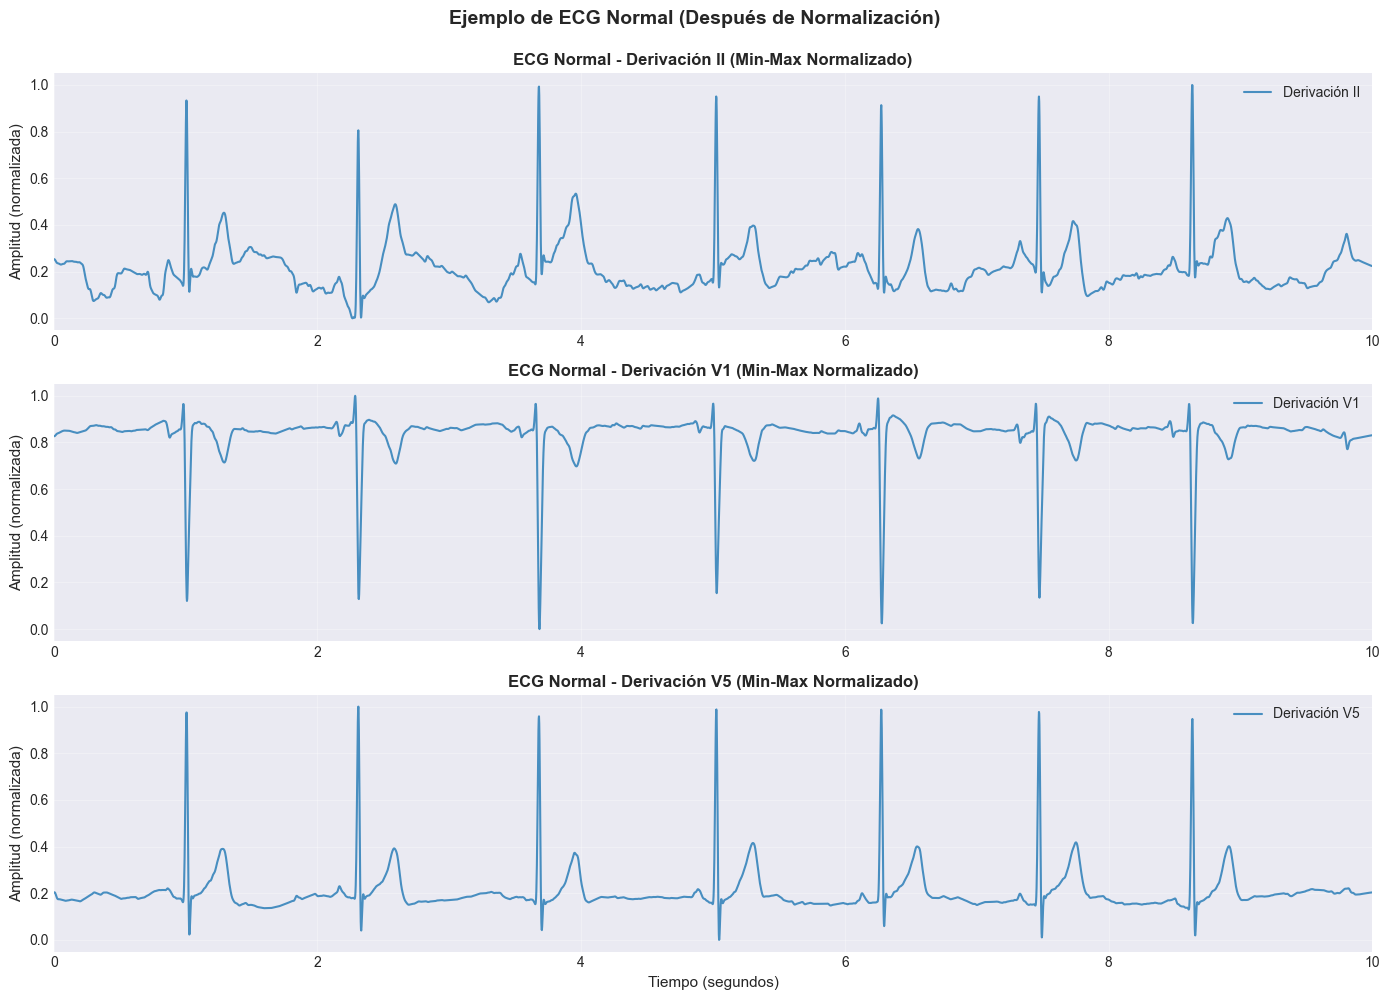


📊 Estadísticas del ECG Normal Normalizado:


,min,max,mean,std
lead,,,,
II,0.0,1.0,0.214299,0.108601
V1,0.0,1.0,0.836380,0.098783
V5,0.0,1.0,0.205256,0.094360


In [8]:
# Visualizar ECG normal normalizado
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
t = np.arange(T) / ecg.SAMPLING_RATE  # Tiempo en segundos

for i, (lead, ax) in enumerate(zip(ecg.TARGET_LEADS, axes)):
    ax.plot(t, example_norm[:, i], linewidth=1.5, alpha=0.8, label=f"Derivación {lead}")
    ax.set_ylabel("Amplitud (normalizada)", fontsize=11)
    ax.set_title(f"ECG Normal - Derivación {lead} (Min-Max Normalizado)", fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    ax.set_xlim(0, 10)

axes[-1].set_xlabel("Tiempo (segundos)", fontsize=11)
plt.suptitle("Ejemplo de ECG Normal (Después de Normalización)", fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Estadísticas del ejemplo normal
print("\n📊 Estadísticas del ECG Normal Normalizado:")
stats_norm = ecg.summarize_signal(example_norm, ecg.TARGET_LEADS)
display(stats_norm)


### 6.2 Visualización: ECG Anómalo (Normalizado)

Si hay anómalos disponibles, mostramos un ejemplo.


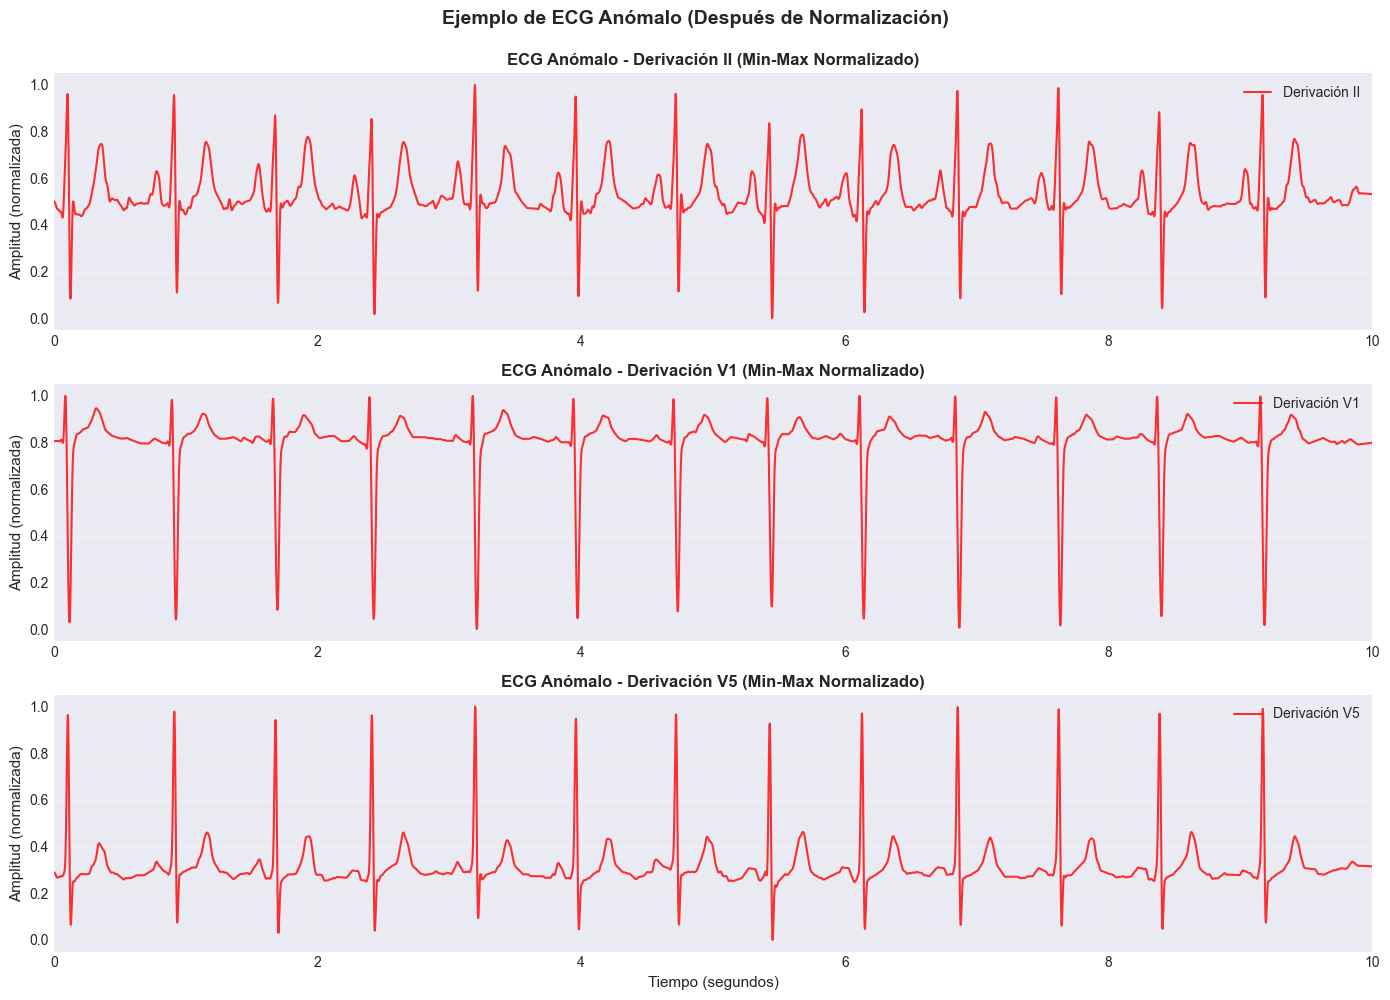


📊 Estadísticas del ECG Anómalo Normalizado:


,min,max,mean,std
lead,,,,
II,0.0,1.0,0.529713,0.111603
V1,0.0,1.0,0.802790,0.136715
V5,0.0,1.0,0.314914,0.104207


In [9]:
if example_anom is not None:
    # Visualizar ECG anómalo normalizado
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    for i, (lead, ax) in enumerate(zip(ecg.TARGET_LEADS, axes)):
        ax.plot(t, example_anom[:, i], linewidth=1.5, alpha=0.8, label=f"Derivación {lead}", color='red')
        ax.set_ylabel("Amplitud (normalizada)", fontsize=11)
        ax.set_title(f"ECG Anómalo - Derivación {lead} (Min-Max Normalizado)", fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right')
        ax.set_xlim(0, 10)
    
    axes[-1].set_xlabel("Tiempo (segundos)", fontsize=11)
    plt.suptitle("Ejemplo de ECG Anómalo (Después de Normalización)", fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Estadísticas del ejemplo anómalo
    print("\n📊 Estadísticas del ECG Anómalo Normalizado:")
    stats_anom = ecg.summarize_signal(example_anom, ecg.TARGET_LEADS)
    display(stats_anom)
else:
    print("⚠ No hay ejemplos anómalos disponibles para visualizar")


### 6.3 Comparación: Antes y Después del Procesamiento

Cargamos el mismo registro en sus diferentes etapas (crudo, filtrado, normalizado) para comparar.


In [ ]:
# Cargar metadata para obtener IDs y códigos de los ECGs
meta_norm_path = ecg.COMBINED_OUTPUT / "meta_norm.csv"
if not meta_norm_path.exists():
    meta_norm_path = ecg.PTB_OUTPUT / "meta_norm.csv"

meta_norm_df = pd.read_csv(meta_norm_path)
print(f"✓ Metadata cargado: {len(meta_norm_df)} registros")
print(f"  Columnas disponibles: {', '.join(meta_norm_df.columns[:10].tolist())}...\n")

# Cargar el mismo registro en diferentes etapas
# Intentar cargar desde el directorio combinado primero, luego PTB
norm_raw_path = ecg.COMBINED_OUTPUT / "X_norm_raw.dat"
norm_filt_path = ecg.COMBINED_OUTPUT / "X_norm_filt.dat"

# Si no existen en el directorio combinado, usar PTB (solo tiene los primeros ECGs)
if not norm_raw_path.exists():
    norm_raw_path = ecg.PTB_OUTPUT / "X_norm_raw.dat"
if not norm_filt_path.exists():
    norm_filt_path = ecg.PTB_OUTPUT / "X_norm_filt.dat"

# Cargar datos crudos/filtrados si están disponibles
has_raw_filt = norm_raw_path.exists() and norm_filt_path.exists()
X_norm_raw_example = None
X_norm_filt_example = None
n_raw_filt = 0

if has_raw_filt:
    X_norm_raw_example, _ = ecg.open_memmap_known_shape(norm_raw_path, T, C, mode="r")
    X_norm_filt_example, _ = ecg.open_memmap_known_shape(norm_filt_path, T, C, mode="r")
    n_raw_filt = min(X_norm_raw_example.shape[0], X_norm_filt_example.shape[0])
    
    print(f"📊 Datos disponibles:")
    print(f"  • Raw/Filtrado: {n_raw_filt} registros (índices 0-{n_raw_filt-1})")
    print(f"  • Normalizado (Combinado): {N_norm} registros (índices 0-{N_norm-1})")
    print(f"  • Todos los ECGs del dataset combinado están disponibles para visualización")
    if n_raw_filt < N_norm:
        print(f"  ⚠ Nota: Los ECGs con índice >= {n_raw_filt} solo mostrarán la versión normalizada\n")
    else:
        print()
else:
    print("⚠ Archivos crudos/filtrados no disponibles. Solo se mostrará la versión normalizada.\n")

# Función para visualizar un ECG específico
def visualizar_ecg(ecg_idx, lead_idx=0, window_seconds=2):
    """
    Visualiza un ECG en diferentes etapas del procesamiento.
    
    Parameters:
    -----------
    ecg_idx : int
        Índice del ECG a visualizar (0 a N_norm-1)
    lead_idx : int
        Índice de la derivación a mostrar (0=II, 1=V1, 2=V5)
    window_seconds : float
        Ventana de tiempo en segundos a mostrar
    """
    # Verificar que el índice es válido
    if ecg_idx < 0 or ecg_idx >= N_norm:
        print(f"⚠ Índice {ecg_idx} fuera de rango. Debe estar entre 0 y {N_norm-1}")
        return
    
    # Cargar datos del ECG seleccionado
    example_norm = np.array(X_norm_mm[ecg_idx])
    
    # Análisis básico de la señal para detectar posibles anomalías
    # Calcular métricas simples que pueden indicar problemas
    signal_mean = np.mean(example_norm)
    signal_std = np.std(example_norm)
    signal_max = np.max(example_norm)
    signal_min = np.min(example_norm)
    
    # Detectar posibles problemas:
    # - Desviación estándar muy baja (señal plana)
    # - Rango muy pequeño (señal comprimida)
    # - Valores fuera del rango esperado [0, 1]
    flags = []
    if signal_std < 0.05:
        flags.append("⚠ Baja variabilidad (std={:.3f})".format(signal_std))
    if (signal_max - signal_min) < 0.1:
        flags.append("⚠ Rango muy pequeño ({:.3f})".format(signal_max - signal_min))
    if signal_max > 1.01 or signal_min < -0.01:
        flags.append("⚠ Valores fuera de rango [0,1]")
    
    # Obtener información del metadata
    if ecg_idx < len(meta_norm_df):
        ecg_meta = meta_norm_df.iloc[ecg_idx]
        source = ecg_meta.get('source_dataset', 'unknown')
        
        # Construir identificador según el dataset
        if source == 'ptbxl':
            ecg_id = ecg_meta.get('ecg_id', 'N/A')
            filename = ecg_meta.get('filename_hr', 'N/A')
            ecg_code = f"PTB-{int(ecg_id) if pd.notna(ecg_id) else 'N/A'}"
            ecg_identifier = f"ECG ID: {int(ecg_id) if pd.notna(ecg_id) else 'N/A'} | File: {filename}"
        elif source == 'mimic':
            subject_id = ecg_meta.get('subject_id', 'N/A')
            study_id = ecg_meta.get('study_id', 'N/A')
            cart_id = ecg_meta.get('cart_id', 'N/A')
            path = ecg_meta.get('path', 'N/A')
            ecg_code = f"MIMIC-S{int(subject_id) if pd.notna(subject_id) else 'N/A'}-St{int(study_id) if pd.notna(study_id) else 'N/A'}"
            ecg_identifier = f"Subject: {int(subject_id) if pd.notna(subject_id) else 'N/A'} | Study: {int(study_id) if pd.notna(study_id) else 'N/A'} | Cart: {int(cart_id) if pd.notna(cart_id) else 'N/A'}"
        else:
            ecg_code = f"IDX-{ecg_idx}"
            ecg_identifier = f"Índice: {ecg_idx}"
        
        # Información adicional
        age = ecg_meta.get('age', 'N/A')
        sex = ecg_meta.get('sex', 'N/A')
        sex_str = "M" if pd.notna(sex) and sex == 1.0 else ("F" if pd.notna(sex) and sex == 0.0 else "N/A")
        
        # Mostrar información del ECG
        print(f"\n{'='*60}")
        print(f"📋 INFORMACIÓN DEL ECG #{ecg_idx}")
        print(f"{'='*60}")
        print(f"  Código: {ecg_code}")
        print(f"  Dataset: {source.upper()}")
        print(f"  {ecg_identifier}")
        if pd.notna(age):
            print(f"  Edad: {int(age) if pd.notna(age) else 'N/A'} años")
        print(f"  Sexo: {sex_str}")
        print(f"  Fila en CSV: {ecg_idx + 2} (índice {ecg_idx} + header + 1-indexing)")
        
        # Mostrar métricas de la señal
        print(f"\n  📊 Métricas de la señal:")
        print(f"    • Media: {signal_mean:.4f}")
        print(f"    • Desv. Est.: {signal_std:.4f}")
        print(f"    • Min: {signal_min:.4f}, Max: {signal_max:.4f}")
        print(f"    • Rango: {signal_max - signal_min:.4f}")
        
        # Mostrar flags de advertencia si hay
        if flags:
            print(f"\n  ⚠️  ADVERTENCIAS:")
            for flag in flags:
                print(f"    {flag}")
            print(f"\n  💡 Revisa este ECG en el CSV (fila {ecg_idx + 2}) para más detalles")
        else:
            print(f"    ✓ Señal parece normal")
        
        print(f"{'='*60}\n")
    else:
        ecg_code = f"IDX-{ecg_idx}"
        print(f"\n{'='*60}")
        print(f"📋 INFORMACIÓN DEL ECG #{ecg_idx}")
        print(f"{'='*60}")
        print(f"  Código: {ecg_code}")
        print(f"  ⚠ No hay metadata disponible para este índice")
        
        # Mostrar métricas de la señal
        print(f"\n  📊 Métricas de la señal:")
        print(f"    • Media: {signal_mean:.4f}")
        print(f"    • Desv. Est.: {signal_std:.4f}")
        print(f"    • Min: {signal_min:.4f}, Max: {signal_max:.4f}")
        print(f"    • Rango: {signal_max - signal_min:.4f}")
        
        # Mostrar flags de advertencia si hay
        if flags:
            print(f"\n  ⚠️  ADVERTENCIAS:")
            for flag in flags:
                print(f"    {flag}")
        else:
            print(f"    ✓ Señal parece normal")
        
        print(f"{'='*60}\n")
    
    # Verificar si hay datos crudos/filtrados para este índice
    has_raw_filt_data = has_raw_filt and ecg_idx < n_raw_filt
    
    if has_raw_filt_data:
        example_raw = np.array(X_norm_raw_example[ecg_idx])
        example_filt = np.array(X_norm_filt_example[ecg_idx])
        num_plots = 3
    else:
        num_plots = 1
    
    # Ventana de visualización
    window_samples = min(int(window_seconds * ecg.SAMPLING_RATE), T)
    t_window = np.arange(window_samples) / ecg.SAMPLING_RATE
    
    # Visualizar comparación para la derivación seleccionada
    fig, axes = plt.subplots(num_plots, 1, figsize=(14, 4 * num_plots))
    if num_plots == 1:
        axes = [axes]
    
    plot_idx = 0
    
    if has_raw_filt_data:
        # Crudo
        axes[plot_idx].plot(t_window, example_raw[:window_samples, lead_idx], 
                         linewidth=1.5, alpha=0.8, color='blue', label='Crudo')
        axes[plot_idx].set_ylabel("Amplitud (mV)", fontsize=11)
        axes[plot_idx].set_title("ECG Crudo (Antes del Procesamiento)", fontsize=12, fontweight='bold')
        axes[plot_idx].grid(True, alpha=0.3)
        axes[plot_idx].legend()
        plot_idx += 1
        
        # Filtrado
        axes[plot_idx].plot(t_window, example_filt[:window_samples, lead_idx], 
                         linewidth=1.5, alpha=0.8, color='green', label='Filtrado')
        axes[plot_idx].set_ylabel("Amplitud (mV)", fontsize=11)
        axes[plot_idx].set_title("ECG Filtrado (Notch 50Hz + Bandpass 0.5-40Hz)", fontsize=12, fontweight='bold')
        axes[plot_idx].grid(True, alpha=0.3)
        axes[plot_idx].legend()
        plot_idx += 1
    
    # Normalizado
    axes[plot_idx].plot(t_window, example_norm[:window_samples, lead_idx], 
                     linewidth=1.5, alpha=0.8, color='red', label='Normalizado')
    axes[plot_idx].set_ylabel("Amplitud (normalizada)", fontsize=11)
    axes[plot_idx].set_title("ECG Normalizado (Min-Max [0, 1])", fontsize=12, fontweight='bold')
    axes[plot_idx].set_xlabel("Tiempo (segundos)", fontsize=11)
    axes[plot_idx].grid(True, alpha=0.3)
    axes[plot_idx].legend()
    
    title_suffix = f" | Ventana: {window_seconds}s"
    if not has_raw_filt_data:
        title_suffix += " (solo normalizado - sin datos crudos/filtrados)"
    
    # Incluir código del ECG en el título
    title = f"ECG #{ecg_idx} ({ecg_code}) - Derivación {ecg.TARGET_LEADS[lead_idx]}{title_suffix}"
    plt.suptitle(title, fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    status = "con todas las etapas" if has_raw_filt_data else "solo normalizado"
    print(f"✓ ECG #{ecg_idx} visualizado correctamente ({status}, Derivación {ecg.TARGET_LEADS[lead_idx]})")

# Crear widget interactivo
if not WIDGETS_AVAILABLE:
    print("⚠ ipywidgets no está disponible. Mostrando visualización estática del ECG por defecto.")
    visualizar_ecg(example_norm_idx, lead_idx=0, window_seconds=2)
else:
    print("=" * 60)
    print("VISUALIZACIÓN INTERACTIVA DE ECGs")
    print("=" * 60)
    print(f"Total de ECGs disponibles: {N_norm}")
    print(f"ECGs en train_norm: {len(splits['train_norm'])}")
    print(f"Usa los controles para cambiar el ECG, derivación y ventana de tiempo\n")
    
    # Permitir visualizar todos los ECGs del dataset combinado
    max_ecg_idx = N_norm - 1
    
    interact(
        visualizar_ecg,
        ecg_idx=IntSlider(
            value=example_norm_idx,
            min=0,
            max=max_ecg_idx,
            step=1,
            description='ECG #:',
            style={'description_width': 'initial'},
            layout={'width': '500px'}
        ),
        lead_idx=IntSlider(
            value=0,
            min=0,
            max=len(ecg.TARGET_LEADS) - 1,
            step=1,
            description='Derivación:',
            style={'description_width': 'initial'},
            layout={'width': '500px'}
        ),
        window_seconds=IntSlider(
            value=2,
            min=1,
            max=10,
            step=1,
            description='Ventana (seg):',
            style={'description_width': 'initial'},
            layout={'width': '500px'}
        )
    )
    
    print("\n💡 Tip: Usa los sliders para explorar diferentes ECGs y derivaciones")
    print(f"💡 Todos los ECGs (0-{max_ecg_idx}) están disponibles para visualización")
    if has_raw_filt and n_raw_filt < N_norm:
        print(f"💡 Los ECGs 0-{n_raw_filt-1} mostrarán todas las etapas (crudo/filtrado/normalizado)")
        print(f"💡 Los ECGs {n_raw_filt}-{max_ecg_idx} mostrarán solo la versión normalizada")


✓ Metadata cargado: 151606 registros
  Columnas disponibles: ecg_id, filename_hr, strat_fold, sex, age, diagnostic_superclass, source_dataset, subject_id, study_id, cart_id...

📊 Datos disponibles:
  • Raw/Filtrado: 9069 registros (índices 0-9068)
  • Normalizado (Combinado): 151606 registros (índices 0-151605)
  • Todos los ECGs del dataset combinado están disponibles para visualización
  ⚠ Nota: Los ECGs con índice >= 9069 solo mostrarán la versión normalizada

VISUALIZACIÓN INTERACTIVA DE ECGs
Total de ECGs disponibles: 151606
ECGs en train_norm: 121284
Usa los controles para cambiar el ECG, derivación y ventana de tiempo



C:\Users\tomas\AppData\Local\Temp\ipykernel_28452\3235982672.py:6: DtypeWarning: Columns (1,5) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_norm_df = pd.read_csv(meta_norm_path)


interactive(children=(IntSlider(value=1, description='ECG #:', layout=Layout(width='500px'), max=151605, style…


💡 Tip: Usa los sliders para explorar diferentes ECGs y derivaciones
💡 Todos los ECGs (0-151605) están disponibles para visualización
💡 Los ECGs 0-9068 mostrarán todas las etapas (crudo/filtrado/normalizado)
💡 Los ECGs 9069-151605 mostrarán solo la versión normalizada


: 

NameError: name 'example_raw' is not defined

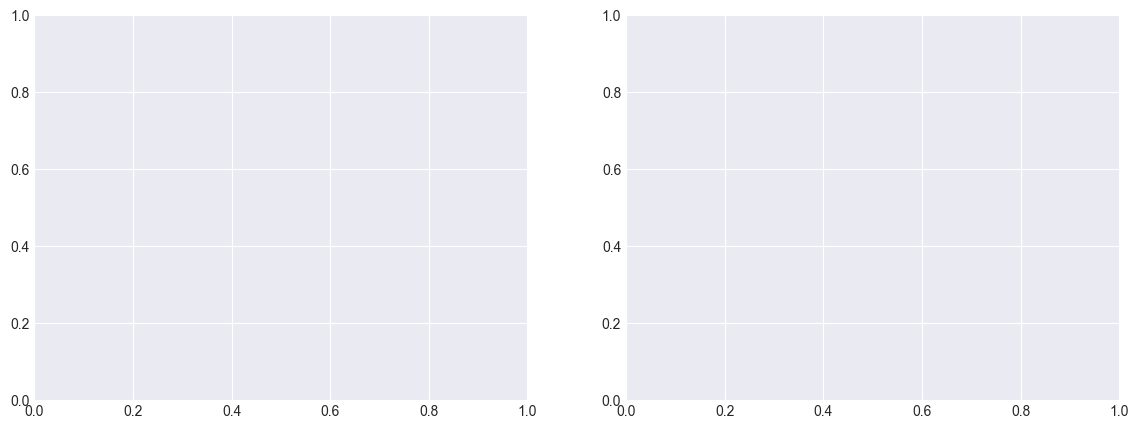

In [14]:
if norm_raw_path.exists():
    # Histograma comparativo
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Antes (crudo)
    axes[0].hist(example_raw.flatten(), bins=100, alpha=0.7, color='blue', edgecolor='black')
    axes[0].set_xlabel("Amplitud (mV)", fontsize=11)
    axes[0].set_ylabel("Frecuencia", fontsize=11)
    axes[0].set_title("Distribución de Valores - Antes (Crudo)", fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Después (normalizado)
    axes[1].hist(example_norm.flatten(), bins=100, alpha=0.7, color='red', edgecolor='black')
    axes[1].set_xlabel("Amplitud (normalizada)", fontsize=11)
    axes[1].set_ylabel("Frecuencia", fontsize=11)
    axes[1].set_title("Distribución de Valores - Después (Normalizado)", fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim(0, 1)
    
    plt.suptitle("Distribución de Amplitudes: Antes vs Después de Normalización", 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Estadísticas de distribución:")
    print(f"  Antes (crudo):")
    print(f"    - Min: {example_raw.min():.4f}, Max: {example_raw.max():.4f}")
    print(f"    - Mean: {example_raw.mean():.4f}, Std: {example_raw.std():.4f}")
    print(f"  Después (normalizado):")
    print(f"    - Min: {example_norm.min():.4f}, Max: {example_norm.max():.4f}")
    print(f"    - Mean: {example_norm.mean():.4f}, Std: {example_norm.std():.4f}")
else:
    print("⚠ Archivo crudo no disponible para comparación")


### 6.5 Visualización Multi-Derivación: Comparación Normal vs Anómalo

Si hay anómalos disponibles, comparamos visualmente un normal y un anómalo en las tres derivaciones.


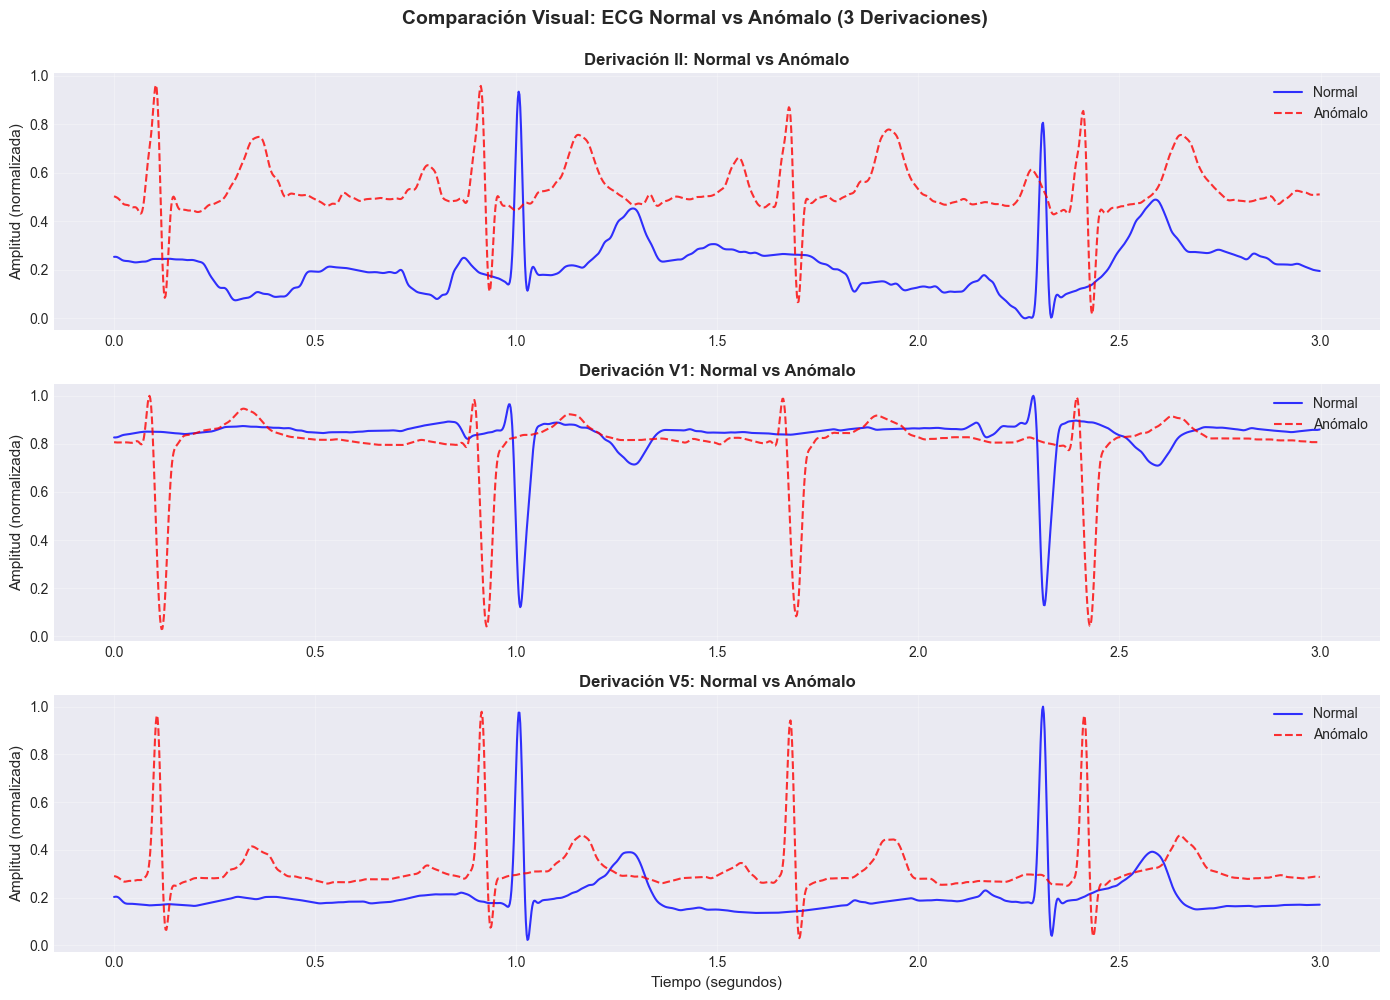

In [12]:
if example_anom is not None:
    # Comparación normal vs anómalo en las 3 derivaciones
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # Ventana de 3 segundos
    window_samples = min(3 * ecg.SAMPLING_RATE, T)
    t_window = np.arange(window_samples) / ecg.SAMPLING_RATE
    
    for i, (lead, ax) in enumerate(zip(ecg.TARGET_LEADS, axes)):
        ax.plot(t_window, example_norm[:window_samples, i], 
                linewidth=1.5, alpha=0.8, label='Normal', color='blue')
        ax.plot(t_window, example_anom[:window_samples, i], 
                linewidth=1.5, alpha=0.8, label='Anómalo', color='red', linestyle='--')
        ax.set_ylabel("Amplitud (normalizada)", fontsize=11)
        ax.set_title(f"Derivación {lead}: Normal vs Anómalo", fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right')
    
    axes[-1].set_xlabel("Tiempo (segundos)", fontsize=11)
    plt.suptitle("Comparación Visual: ECG Normal vs Anómalo (3 Derivaciones)", 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
else:
    print("⚠ No hay ejemplos anómalos disponibles para comparación")


## 7. Resumen Final

Resumen completo del pipeline ejecutado y verificación final.


In [15]:
print("=" * 60)
print("RESUMEN FINAL DEL PIPELINE")
print("=" * 60)

final_stats = ecg.get_dataset_stats(dataset="combined")

print(f"\n📊 ESTADÍSTICAS GENERALES:")
print(f"  • Total ECG: {final_stats['total_ecg']}")
print(f"  • ECG Normales: {final_stats['total_normals']}")
print(f"  • ECG Anómalos: {final_stats['total_anomalies']}")

if "train" in final_stats:
    print(f"\n📈 DISTRIBUCIÓN POR SPLIT:")
    print(f"  TRAIN:")
    print(f"    - Normales: {final_stats['train']['normals']}")
    print(f"    - Anómalos: {final_stats['train']['anomalies']} ✓ (debe ser 0)")
    print(f"  VALIDACIÓN:")
    print(f"    - Normales: {final_stats['val']['normals']}")
    print(f"    - Anómalos: {final_stats['val']['anomalies']}")
    print(f"  TEST:")
    print(f"    - Normales: {final_stats['test']['normals']}")
    print(f"    - Anómalos: {final_stats['test']['anomalies']}")

print(f"\n✅ VERIFICACIONES:")
print(f"  ✓ Datos cargados correctamente")
print(f"  ✓ Filtrado y normalización aplicados")
print(f"  ✓ Splits generados con seed={ecg.RNG_SEED} (reproducible)")
if "train" in final_stats:
    if final_stats['train']['anomalies'] == 0:
        print(f"  ✓ Train contiene SOLO normales (correcto para aprendizaje no supervisado)")
    else:
        print(f"  ⚠ ADVERTENCIA: Train contiene {final_stats['train']['anomalies']} anómalos")

print(f"\n🎯 El dataset está listo para entrenamiento no supervisado!")
print(f"   - Usa los índices en {ecg.COMBINED_OUTPUT / 'splits'} para cargar batches")
print(f"   - Train: solo normales (índices en idx_norm_train.npy)")
print(f"   - Valid/Test: normales + anómalos (índices separados)")


RESUMEN FINAL DEL PIPELINE

📊 ESTADÍSTICAS GENERALES:
  • Total ECG: 152606
  • ECG Normales: 151606
  • ECG Anómalos: 1000

📈 DISTRIBUCIÓN POR SPLIT:
  TRAIN:
    - Normales: 121284
    - Anómalos: 0 ✓ (debe ser 0)
  VALIDACIÓN:
    - Normales: 15160
    - Anómalos: 100
  TEST:
    - Normales: 15162
    - Anómalos: 900

✅ VERIFICACIONES:
  ✓ Datos cargados correctamente
  ✓ Filtrado y normalización aplicados
  ✓ Splits generados con seed=42 (reproducible)
  ✓ Train contiene SOLO normales (correcto para aprendizaje no supervisado)

🎯 El dataset está listo para entrenamiento no supervisado!
   - Usa los índices en S:\Proyecto final\data\combined_ptbxl_mimic_500hz_iv1v5\splits para cargar batches
   - Train: solo normales (índices en idx_norm_train.npy)
   - Valid/Test: normales + anómalos (índices separados)


s:\Proyecto final\Books\ecg_preprocessing.py:1229: DtypeWarning: Columns (1,5) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_norm = pd.read_csv(output_dir / "meta_norm.csv")
